<a href="https://colab.research.google.com/github/Sahel-Eskandar/Daily_Climate/blob/main/Daily_climate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Weather Report from NCEI

In [62]:
import numpy as np
import pandas as pd

The data for this project comes from a subset of The National Centers for Environmental Information (NCEI) [Global Historical Climatology Network daily (GHCNd)](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe - it's a wonderfully large dataset to play with! This is stored in the file: `assets/weather.csv`

Each row in this datafile corresponds to a single observation from a weather station, and has the following variables:
* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this project, we plan:

1. Write a python notebook which plots line graphs of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015. (Based on the graph, do you think extreme weather is getting more frequent in 2015?)
3. Removing the leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Leverage principles of visualization when developing the solution. Considering issues such as legends, labels, and chart junk.

In [63]:
#  I'll be using the folium package to render the data into a map in Jupyter.
import folium
import pandas as pd

# get the location information for this dataset
df = pd.read_csv('/content/BinSize_d400.csv')
station_locations_by_hash = df[df['hash'] == 'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89']

# get longitude and lattitude to plot
lons = station_locations_by_hash['LONGITUDE'].tolist()
lats = station_locations_by_hash['LATITUDE'].tolist()

# plot on a beautiful folium map
my_map = folium.Map(location = [lats[0], lons[0]], height = 500,  zoom_start = 9)
for lat, lon in zip(lats, lons):
    folium.Marker([lat, lon]).add_to(my_map)

# render map in Jupyter
display(my_map)

## Step 1
Loading the dataset and transforming the data into Celcius then extract all of the rows which have minimum or maximum temperatures.


In [64]:
import pandas as pd
df = pd.read_csv('/content/weather.csv')
df.head()


,ID,Date,Element,Data_Value
0,USW00094889,2014-11-12,TMAX,22
1,USC00208972,2009-04-29,TMIN,56
2,USC00200032,2008-05-26,TMAX,278
3,USC00205563,2005-11-11,TMAX,139
4,USC00200230,2014-02-27,TMAX,-106


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165085 entries, 0 to 165084
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ID          165085 non-null  object
 1   Date        165085 non-null  object
 2   Element     165085 non-null  object
 3   Data_Value  165085 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 5.0+ MB


Convert the Data_Value to C by deviding by 10

In [66]:
#transform the Data_Value column
df.Data_Value  = df.Data_Value / 10

In [67]:
#DataFrame of minimum temperatures by date
df_min = df[df.Element== 'TMIN']
df_min = df_min.drop(columns=['Element'])
df_min = df_min.set_index('Date',drop= True)
df_min.index = pd.to_datetime(df_min.index)

In [68]:
#DataFrame of maximum temperatures by date
df_max = df[df.Element == 'TMAX']
df_max = df_max.drop(columns=['Element'])
df_max = df_max.set_index('Date',drop= True)
df_max.index = pd.to_datetime(df_max.index)

## Step 2
In order to visualize the data I plot the min and max data for each day of the year between the years 2005 and 2014 across all weather stations. But I need to find out when the min or max temperature in 2015 falls below the min or rises above the max for the previous decade.

After step 1 I have two Series objects with min and max times for the years 2005 through 2015. By using Pandas `groupby` to create max and min temperature Series objects across all weather stations for each day of these years, and then deal with the records for February 29 (the leap year) by dropping them.

In [69]:
#DataFrame of maximum temperature by date
df_max_avg = df_max.groupby(df_max.index).agg({"Data_Value":np.max})
df_max_avg = df_max_avg[df_max_avg.index.day_of_year != 366]
df_max_avg.head()

,Data_Value
Date,
2005-01-01,15.6
2005-01-02,13.9
2005-01-03,13.3
2005-01-04,3.9
2005-01-05,3.3


In [70]:
#DataFrame of minimum temperatures by date
df_min_avg = df_min.groupby(df_min.index).agg({"Data_Value":np.min})
df_min_avg = df_min_avg[df_min_avg.index.day_of_year != 366]
df_min_avg.head()

,Data_Value
Date,
2005-01-01,-5.6
2005-01-02,-5.6
2005-01-03,0.0
2005-01-04,-3.9
2005-01-05,-9.4


## Step 3
After grouping the daily max and min temperatures for each day of the years 2005 through 2015, I can separate out the data for 2015. Then by using the Pandas `groupby` function, find the max and min of the temperature data for each __day of the year__ for the 2005-2014 data.


In [71]:
#the minimum values for the day of the year for 2005 through 2014
df_min_avg_prev = df_min_avg[df_min_avg.index.year < 2015]
df_min_prev = df_min_avg_prev.groupby(df_min_avg_prev.index.day_of_year).agg({"Data_Value":np.min})

In [72]:
#the maximum values for the day of the year for 2005 through 2014
df_max_avg_prev = df_max_avg[df_max_avg.index.year < 2015]
df_max_prev = df_max_avg_prev.groupby(df_max_avg_prev.index.day_of_year).agg({"Data_Value":np.max})

In [73]:
#the minimum values for the years 2015
df_min_avg_2015 = df_min_avg[df_min_avg.index.year == 2015]
df_min_2015 = df_min_avg_2015.groupby(df_min_avg_2015.index.day_of_year).agg({"Data_Value":np.min})

In [74]:
#the maximum values for the years 2015
df_max_avg_2015 = df_max_avg[df_max_avg.index.year == 2015]
df_max_2015 = df_max_avg_2015.groupby(df_max_avg_2015.index.day_of_year).agg({"Data_Value":np.max})

## Step 4
Now it's time to plot! By using matplotlib to plot line graphs of the min and max temperatures for the years 2005 through 2014 and to scatter plot for the daily 2015 temperatures that exceeded those values.

In [75]:
observation_dates = pd.date_range('01-01-2015', periods=365, freq='D')

In [76]:
df_min_2015['Date'] = observation_dates
df_max_2015['Date'] = observation_dates,

In [84]:
df_low_2015 = df_min_2015[df_min_2015.Data_Value < df_min_prev.Data_Value]
df_low_2015.set_index(['Date'],drop=True, inplace= True)
df_low_2015.head()

,Data_Value
Date,
2015-01-05,-15.5
2015-01-11,-20.0
2015-02-03,-23.8
2015-02-14,-23.9
2015-02-15,-26.0


In [82]:
df_high_2015 = df_max_2015[df_max_2015.Data_Value > df_max_prev.Data_Value]
df_high_2015.set_index(['Date'],drop=True, inplace= True)
df_high_2015.head()

,Data_Value
Date,
2015-02-09,8.3
2015-04-17,27.8
2015-05-07,30.6
2015-05-08,33.3
2015-05-11,30.6


In [22]:
import matplotlib.pyplot as plt
from calendar import month_abbr

In [23]:
from matplotlib.ticker import NullFormatter
from matplotlib.dates import MonthLocator, DateFormatter

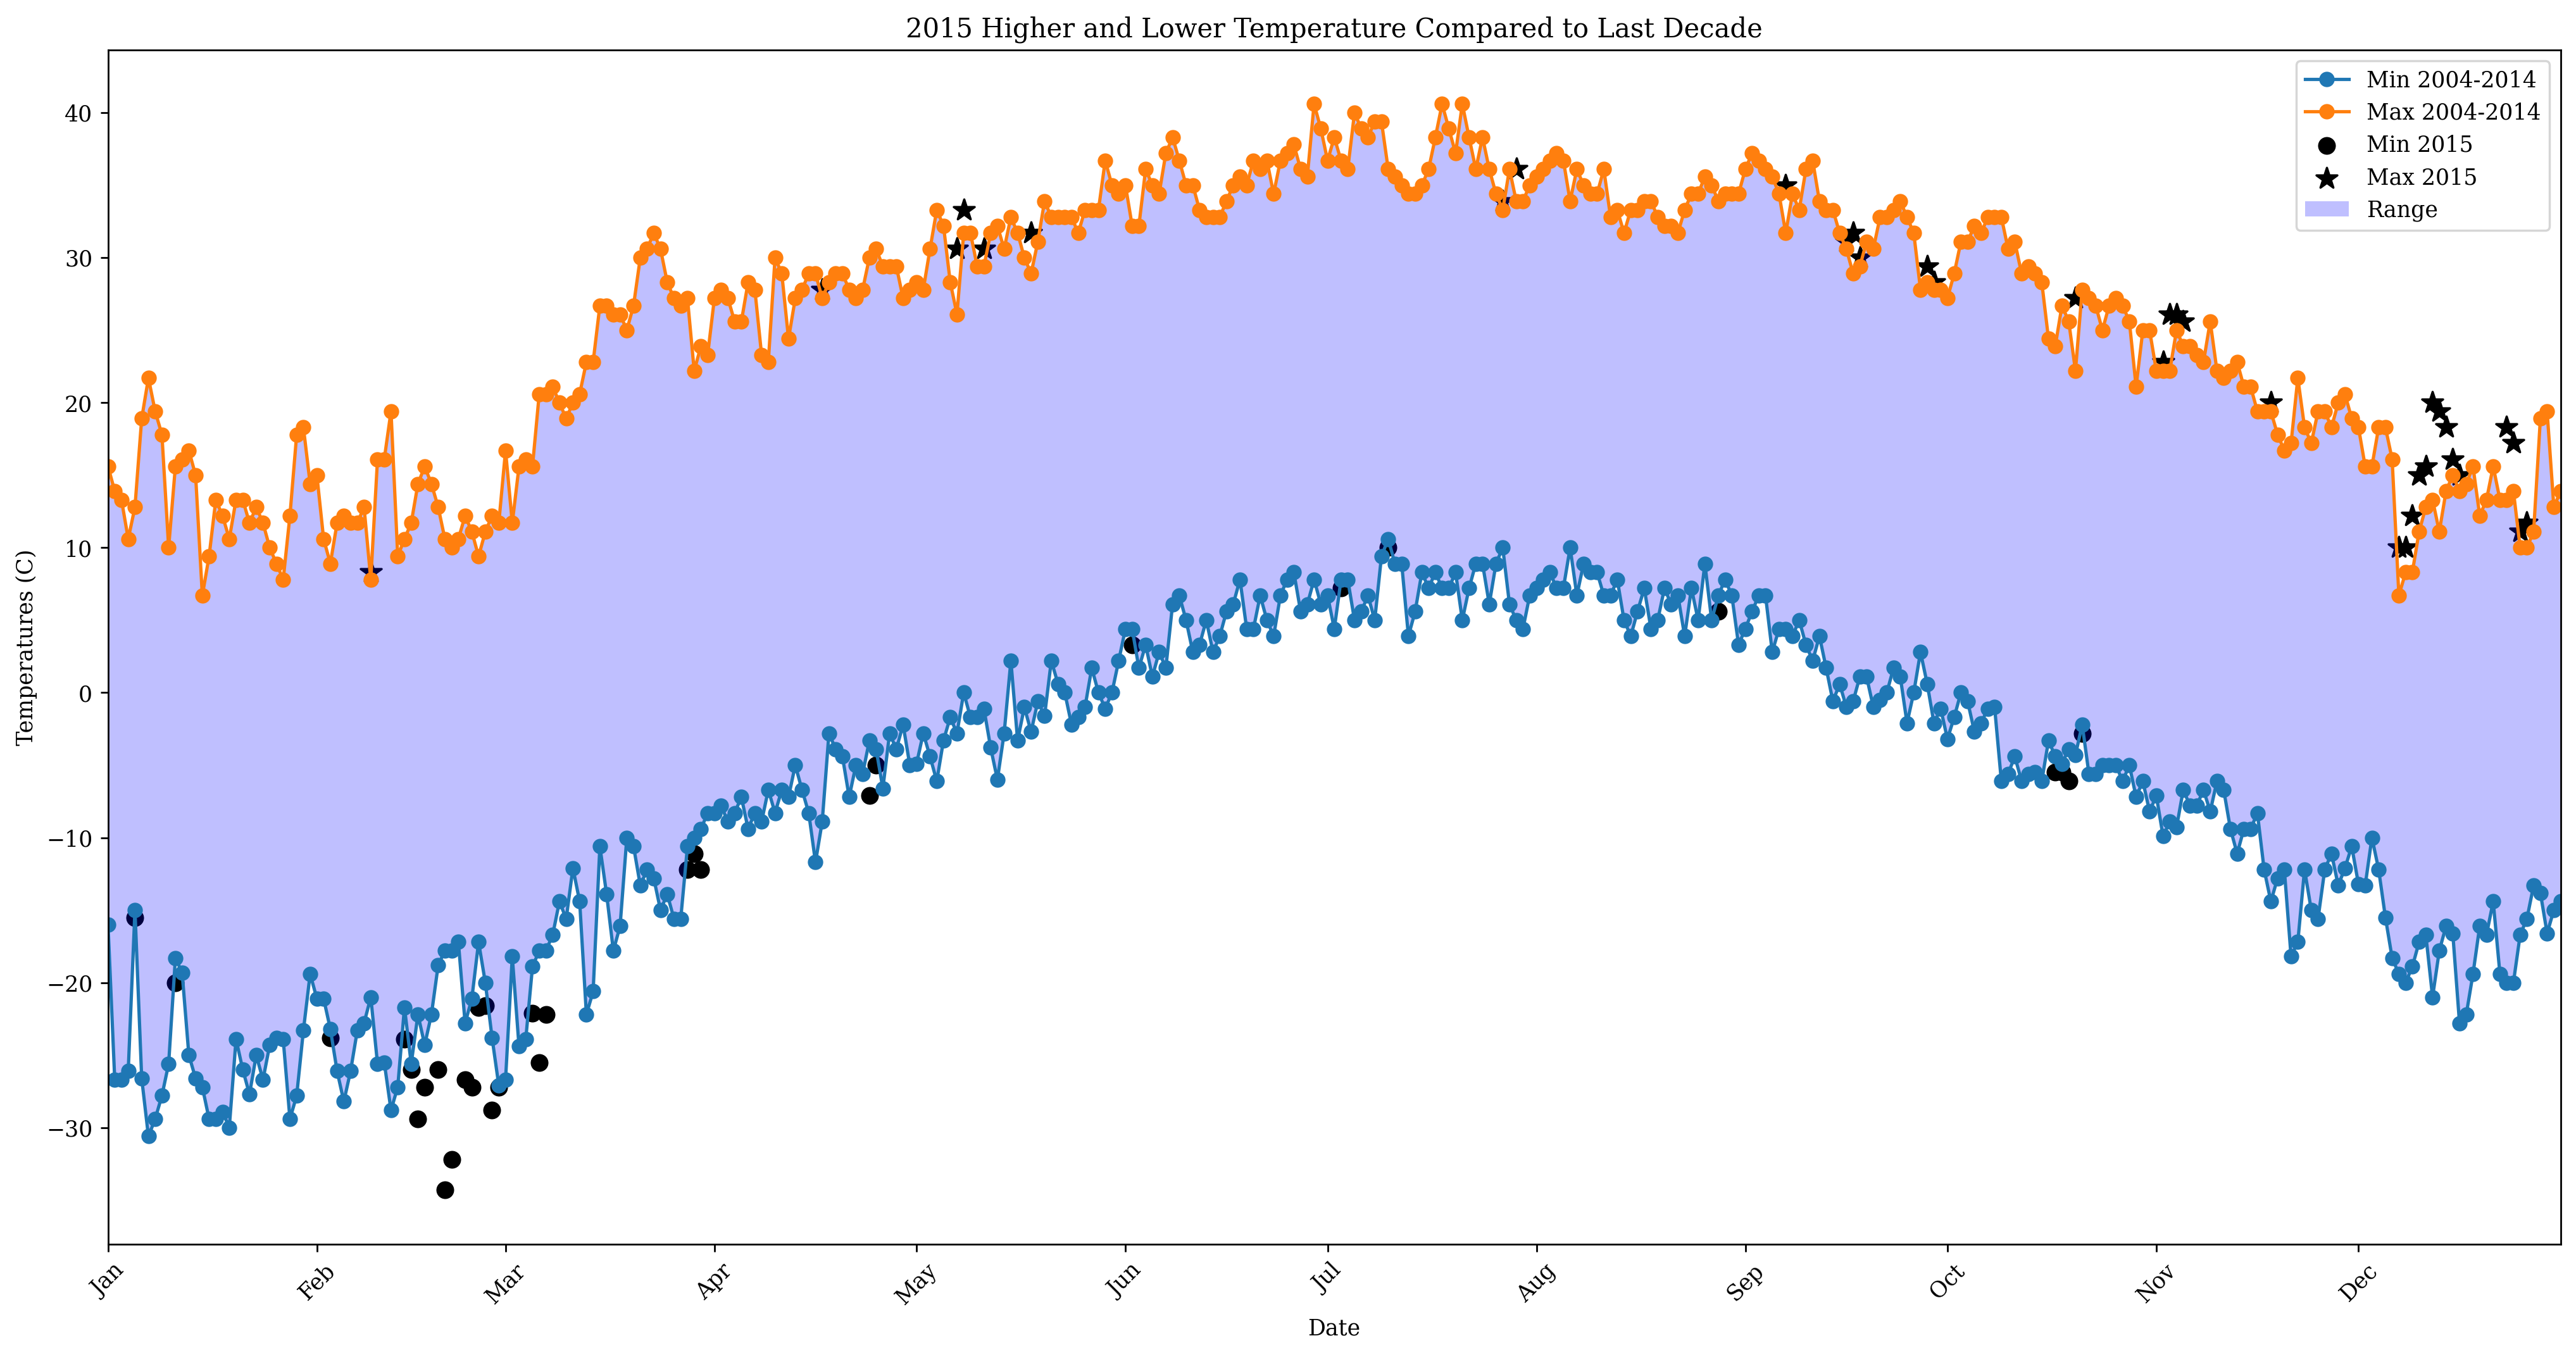

In [92]:
plt.figure(figsize=(20, 10),dpi=250);
observation_dates = pd.date_range('01-01-2015', periods=365, freq='D')
plt.plot(observation_dates, df_min_prev.Data_Value, '-o',  observation_dates, df_max_prev.Data_Value, '-o');
plt.scatter(df_low_2015.index, df_low_2015.Data_Value,marker= '.',s=200, c= 'black')
plt.scatter(df_high_2015.index,df_high_2015.Data_Value,marker= '*',s=100, c= 'black')
plt.rcParams["font.family"] = "serif"
# Now lets get a variable which points at the x axis
x = plt.gca().xaxis
# Now we can iterate through each one and rotate the tick labels
for item in x.get_ticklabels():
    item.set_rotation(45)
ax = plt.gca()
ax.set_xlabel('Date')
ax.set_ylabel('Temperatures (C)')
ax.set_title('2015 Higher and Lower Temperature Compared to Last Decade')
ax.set_xlim([observation_dates[0], observation_dates[-1]])
ax.fill_between(observation_dates, df_min_prev.Data_Value, df_max_prev.Data_Value, facecolor='blue', alpha=0.25)
plt.legend(['Min 2004-2014', 'Max 2004-2014','Min 2015', 'Max 2015', 'Range'])
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%b'))